# 07. Analytical Solution of Multi-spore Diffusion
## Numerical experiments - Week 03/2025

_Boyan Mihaylov, MSc Computational Science (UVA/VU)_

## 1. Derivation of Analytical Scheme

The general solution for the concentration on a 3D lattice with an initial delta pulse at $(x,y,z)=(0,0,0)$ of size $c_0\times V$, where $c_0$ is the initial concentration in the spore and $V$ is the volume of the source, follows the Green's function:

$$
\begin{equation}
c(x,y,z,t)=G(x,y,z,t)=\frac{c_0V}{(4\pi Dt)^{3/2}}e^{-\frac{\Delta{x}^2+\Delta{y}^2+\Delta{z}^2}{4Dt}}
\end{equation}
$$

Or, alternatively, defining $|\vec{r}|=\sqrt{\Delta{x}^2+\Delta{y}^2+\Delta{z}^2}$ as the distance from the measured point to the source:

$$
\begin{equation}
c(\vec{r},t)=G(|\vec{r}|,t)=\frac{c_0V}{(4\pi Dt)^{3/2}}e^{-\frac{|\vec{r}|^2}{4Dt}}
\end{equation}
$$

It is assumed for now that the spores are small compared to the scale of the observed domain and are a negligable obstacle for diffusion. However, they do add new concentration to the system, at a rate determined by the permeation through their cell wall. If this rate is denoted as $Q$, the concentration at a point in space incorporates the accumulation of solute added to the system over time:

$$
\begin{equation}
c(\vec{r},t)=\int_0^t{Q{(t')}G{(\vec{r}, t-t')}dt'}
\end{equation}
$$

The inhibitor release rate at time $t$ can be expressed as

$$
\begin{equation}
Q{(t)}=JA,
\end{equation}
$$

where $J$ is the flux through the cell wall and $A$ is the spore surface area. The flux is defined as

$$
\begin{equation}
J=P_s\Delta{c_s{(t)}},
\end{equation}
$$

with $P_s$ being the permeation constant (measured in units of velocity) and $\Delta{c_s{(t)}}$ the concentration difference between the spore and the exterior. This concentration difference evolves from an initial difference $\Delta{c_s{(0)}}$ as follows:

$$
\begin{equation}
\Delta{c_s{(t)}}=\Delta{c_s{(0)}}e^{-t/\tau},
\end{equation}
$$

where $\tau=\frac{V}{AP_s}$. The initial concentration drop can be thought of as the difference between the concentration at the interior of the spore interface and the concentration immediately outside of it. Following the previous assumption about the spore neglected as an obstacle, the location just outside of it is the entry point for new concentration, namely $\vec{r}_0=(x_0, y_0, z_0)$. Therefore:

$$
\begin{equation}
\Delta{c_s{(0)}}=c_0-c(\vec{r}_0,0)
\end{equation}
$$

But since no prior inhibitor is assumed just outside the spore at $t=0$, this simplifies to

$$
\begin{equation}
\Delta{c_s{(0)}}=c_0
\end{equation}
$$

Thus, the concentration transport at time $t$ amounts to

$$
\begin{equation}
Q{(t)}=AP_sc_0e^{-\frac{P_sAt}{V}}.
\end{equation}
$$

Plugging this equation into the expression for the concentration and substituting the respective Green's function yields:

$$
\begin{equation}
c(\vec{r},t)=\int_0^t{AP_sc_0e^{-\frac{P_sAt'}{V}}\frac{c_0V}{(4\pi D(t-t'))^{3/2}}e^{-\frac{|\vec{r}|^2}{4D(t-t')}}dt'}
\end{equation}
$$

The integral can be simplified by defining $\tau'=t-t'$, such that $t'=t-\tau'$ and $dt'=-d\tau'$:

$$
\begin{equation}
c(\vec{r},t)=AP_s\frac{c_0^2V}{(4\pi D)^{3/2}}\int_0^t{\frac{1}{\tau'^{3/2}}\exp{\left(-\frac{P_sA(t-\tau')}{V}-\frac{|\vec{r}|^2}{4D\tau'}\right)}d\tau'}
\end{equation}
$$

$$
\begin{equation}
c(\vec{r},t)=\frac{AVP_sc_0^2}{(4\pi D)^{3/2}}e^{-\frac{P_sAt}{V}}\int_0^t{\tau'^{-3/2}\exp{\left(-\frac{P_sA\tau'}{V}-\frac{|\vec{r}|^2}{4D\tau'}\right)}d\tau'}
\end{equation}
$$

Now, assuming that there are $M$ sources which start releasing simultaneously with the same $c_0$, the resulting concentration over the lattice is simply the sum of the contributions from each source:

$$
\begin{equation}
c(\vec{r},t)=\frac{AVP_sc_0^2}{(4\pi D)^{3/2}}e^{-\frac{P_sAt}{V}}\sum_{i=0}^{M}{\int_0^t{\tau'^{-3/2}\exp{\left(-\frac{P_sA\tau'}{V}-\frac{|\vec{r}_i|^2}{4D\tau'}\right)}d\tau'}},
\end{equation}
$$

where $|\vec{r}_i|=\sqrt{\Delta{x_i}^2+\Delta{y_i}^2+\Delta{z_i}^2}$ is the respective distance to a single source with index $i$. At the spore, $|\vec{r}_i|=0$ and the above expression simplifies to

$$
\begin{equation}
c(\vec{r}_0,t)=\frac{AVP_sc_0^2}{(4\pi D)^{3/2}}e^{-\frac{P_sAt}{V}}\sum_{i=0}^{M}{\int_0^t{\tau'^{-3/2}\exp{\left(-\frac{P_sA\tau'}{V}\right)}d\tau'}}.
\end{equation}
$$

## 2. Numerical Procedure

The evaluation of $c(\vec{r},t)$ is performed by computing the prefactor and iteratively summing the contributions from the separate spore sources. The integral is thereby solved using the trapezoid rule with a step of $\Delta{\tau'}=0.01$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import diffusion as diff

In [2]:
def concentration_from_permeating_sources(x, t_max, x_sources, c0, D, Ps, A, V, dt=0.001, n_frames=10):
    """
    Compute the concentration at a given point and time
    due to singular permeating sources. The integral is 
    computed using the trapezoidal rule.
    inputs:
        x (numpy array): 3D positions of the observation point
        t_max (float): maximum time of observation
        x_sources (numpy array): 3D positions of the sources
        c0 (float): initial concentration at the sources
        D (float): diffusion coefficient
        Ps (float): source release rate
        A (float): source area
        V (float): source volume
        dt (float): time step size
        n_frames (int): number of frames to compute
    """

    # Integration times
    t_vals = np.arange(dt, t_max+dt, dt)

    # Sampling times
    t_samples = np.linspace(0, t_max, n_frames)
    sample_indices = np.searchsorted(t_vals, t_samples)

    prefactors = A * Ps * c0 / np.power(4 * np.pi * D, 3/2) * np.exp(-Ps*A*t_samples/V)

    # Iterate over sources
    src_sums = np.zeros((x_sources.shape[0], t_samples.shape[0], x.shape[0]))
    for i, x_src in enumerate(x_sources):
        exps = np.exp(- Ps * A * t_vals[:, np.newaxis] / V - np.linalg.norm(x - x_src[np.newaxis, :], axis=1)**2 / (4 * D * t_vals[:, np.newaxis]))
        G = exps / np.sqrt(t_vals[:, np.newaxis] ** 3)
        for j, t in enumerate(t_samples):
            src_sums[i, j] = np.trapz(G[:sample_indices[j]], t_vals[:sample_indices[j]][:, np.newaxis], axis=0)

    t_samples_effective = t_vals[sample_indices]
    results = prefactors[:, np.newaxis] * np.sum(src_sums, axis=0)
    
    return results, t_samples_effective

## 3. Test and Comparison

The analytical method is tested for its correctness by several comparisons to numerical simulations with equivalent parameters. First, a simple evolution of the concentration at a distance $\delta=5$ microns from the source is observed over time, varying the integration time step $\Delta{t}$.

<>:25: SyntaxWarning: invalid escape sequence '\D'
<>:25: SyntaxWarning: invalid escape sequence '\D'
C:\Users\mihbo\AppData\Local\Temp\ipykernel_2600\158117402.py:25: SyntaxWarning: invalid escape sequence '\D'
  ax.plot(ts_analytical, c_analytical, 'o-', label=f'$\Delta t$={dt}')


t_vals shape: (144000000,)
t_vals shape: (38630820,)
t_vals shape: (10363474,)
t_vals shape: (2780205,)
t_vals shape: (745845,)
t_vals shape: (200088,)
t_vals shape: (53678,)
t_vals shape: (14400,)


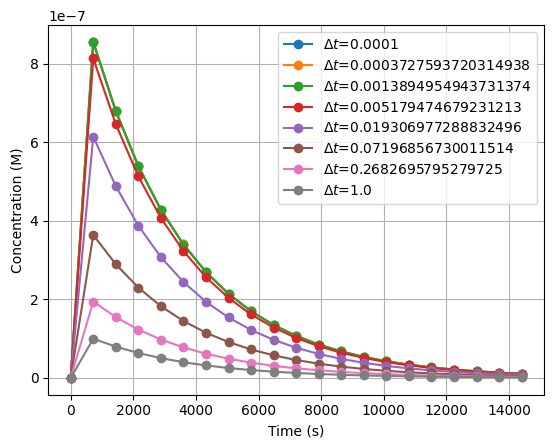

In [181]:
# Inputs
N = 64  # Number of grid points
dx = 5  # Grid spacing in microns
D = 600  # micron^2/s
Ps = 0.0002675353069511818 # microns/s
V = 125 # microns^3
A = 150 # microns^2

src_idx = (N//2, N//2, N//2)  # Source index
pt_sources = np.array([np.array(src_idx) * dx])  # Source positions
pt_idx = (N//2, N//2 + 1, N//2)  # Observation point
pt_obs = np.array([np.array(pt_idx) * dx])  # Observation positions

c0 = 1.018  # Initial concentration at sources in M
t_max = 14400  # Maximum time in seconds
n_times = 20  # Number of time points

# Plot the concentration at the observation point
fig, ax = plt.subplots()

dts = 10**np.linspace(-4, 0, 8)
for dt in dts:
    c_analytical, ts_analytical = concentration_from_permeating_sources(pt_obs, t_max, pt_sources, c0, D, Ps, A, V, dt=dt, n_frames=n_times+1)

    ax.plot(ts_analytical, c_analytical, 'o-', label=f'$\Delta t$={dt}')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Concentration (M)')
ax.set_yscale('log')
# ax.set_ylim(0, 1)
ax.grid()
ax.legend()

The solution converges to a consistent values for an integration step of $\Delta{t}\le 0.001$.

In [97]:
reload(diff)

<module 'diffusion' from 'd:\\MSc Computational Science\\Master Thesis\\msc-thesis\\Code\\diffusion.py'>

Next, a lattice of size $N=64$ ($L=320\mu\textrm{m}$) is used with a single source at $(x_{0},y_{0},z_{0})=(160, 160, 160)$. The experiment time is set to $t=3600$ and the final concentration is sampled at the locations of the source as well as at an additional point $(x_s, y_s, z_s)=(150, 160, 160)$. This way the source and the second sampling point are positioned close enough to make any near-source diffusion noticeable, while keeping enough distance from the boundary to avoid the influence of its periodicity.

The rest of the parameters are set to their values from the previous experiments.

In [3]:
# Inputs
N = 256  # Number of grid points
dx = 5  # Grid spacing in microns
D = 600  # micron^2/s
Ps = 0.0002675353069511818 # microns/s
V = 125 # microns^3
A = 150 # microns^2

sample_dist = 8
src_idx = (N//2, N//2, N//2)  # Source index
pt_sources = np.array([np.array(src_idx) * dx])  # Source positions
xs_obs = np.linspace(0, N * dx, N // sample_dist + 1)  # Grid points
ys_obs = np.linspace(0, N * dx, N // sample_dist + 1)  # Grid points
z_obs = (N // 2) * dx
xs_obs, ys_obs = np.meshgrid(xs_obs, ys_obs)
pt_obs = np.vstack([xs_obs.flatten(), ys_obs.flatten(), np.ones(xs_obs.size) * z_obs]).T
print(f"Sources: {pt_sources}")
# print(f"Observation points: {pt_obs}")

c0 = 1.018  # Initial concentration at sources in M
t_max = 3600  # Maximum time in seconds
n_times = 5  # Number of time points

# Compute the concentration at each observation point using the analytical solution
ts_analytical = np.linspace(0, t_max, n_times+1)  # Time points
c_analytical, ts_analytical = concentration_from_permeating_sources(pt_obs, t_max, pt_sources, c0, D, Ps, A, V, n_frames=n_times+1)

# Compute the concentration at each observation point using the numerical solution
c_init = np.zeros((N, N, N))
c_init[src_idx] = c0
c_numerical, ts_numerical, _ = diff.diffusion_time_dependent_GPU(c_init, t_max, D, Db=None, Ps=Ps, n_save_frames=n_times, spore_idx=src_idx)

Sources: [[640 640 640]]
3D simulation with 3D periodic spores
Using D = 600, Db = 0.0013376765347559091, Ps = 0.0002675353069511818
Simulation running for 720000 steps on a lattice of size [1280 1280 1280] microns.


The results from the simulations are compared in a plot.

<>:39: SyntaxWarning: invalid escape sequence '\m'
<>:40: SyntaxWarning: invalid escape sequence '\m'
<>:39: SyntaxWarning: invalid escape sequence '\m'
<>:40: SyntaxWarning: invalid escape sequence '\m'
C:\Users\mihbo\AppData\Local\Temp\ipykernel_21300\3365550415.py:39: SyntaxWarning: invalid escape sequence '\m'
  axs[0].set_xlabel("$x [\mu m]$")
C:\Users\mihbo\AppData\Local\Temp\ipykernel_21300\3365550415.py:40: SyntaxWarning: invalid escape sequence '\m'
  axs[0].set_ylabel("$y [\mu m]$")


Analytical time: 2160.0000000000005
Numerical time: 2160.0
Analytical min: 1.3655490590955006e-09, max: 6.555761335736694e-08
Numerical min: 2.908251102102255e-08, max: 6.104040733526464e-07


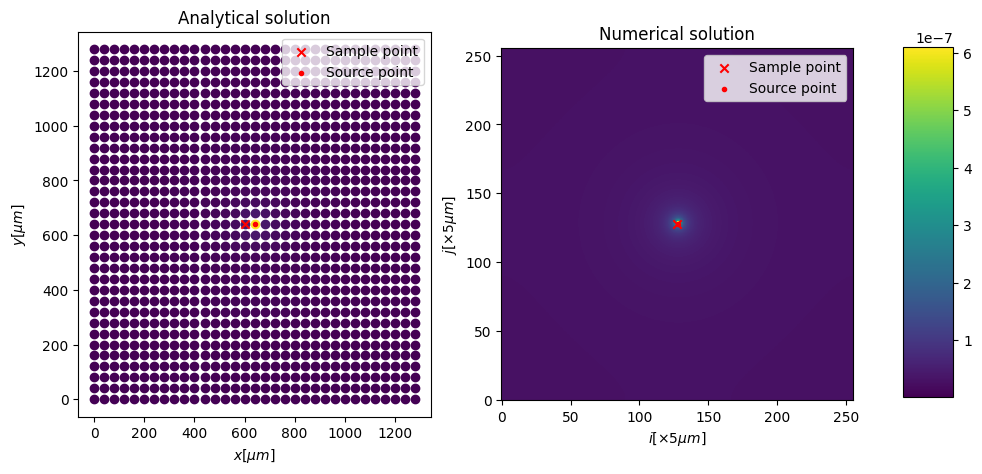

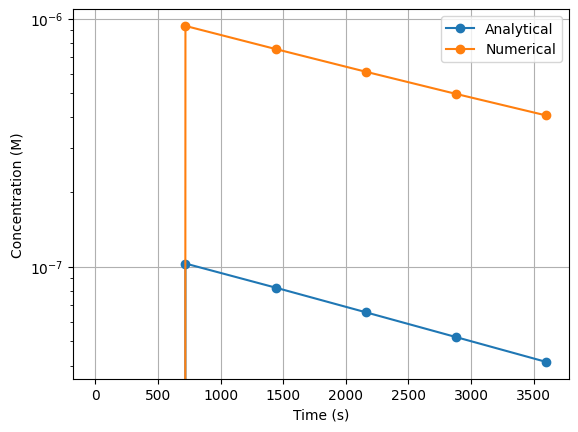

In [4]:
eval_time_idx = 3

print(f"Analytical time: {ts_analytical[eval_time_idx]}")
print(f"Numerical time: {ts_numerical[eval_time_idx]}")

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
palette = plt.get_cmap('viridis')

# Get analytical range
c_an_mask = np.ones((N//sample_dist+1)**2, dtype=bool)
src_idx_an = (N//sample_dist//2, N//sample_dist//2)
src_idx_an_flat = src_idx_an[0] * (N//sample_dist+1) + src_idx_an[1]
c_an_mask[src_idx_an_flat] = False
c_an_medium = c_analytical[eval_time_idx][c_an_mask]
c_an_min = np.min(c_an_medium)
c_an_max = np.max(c_an_medium)
print(f"Analytical min: {c_an_min}, max: {c_an_max}")

# Get numerical range
c_num_slice = c_numerical[eval_time_idx, :, :, src_idx[2]].T

# Exclude the source point index
c_num_mask = np.ones((N, N), dtype=bool)
c_num_mask[src_idx[0], src_idx[1]] = False
c_num_medium = c_num_slice[c_num_mask]

c_num_min = np.min(c_num_medium)
c_num_max = np.max(c_num_medium)
print(f"Numerical min: {c_num_min}, max: {c_num_max}")

min_val = min(c_an_min, c_num_min)
max_val = max(c_an_max, c_num_max)

# Plot analytical solution
for i, pt in enumerate(pt_obs):
    c = c_analytical[:, i][-1]
    axs[0].scatter(pt[0], pt[1], color=palette((c - min_val) / (max_val - min_val)))
axs[0].set_title("Analytical solution")
axs[0].set_xlabel("$x [\mu m]$")
axs[0].set_ylabel("$y [\mu m]$")

# Plot source and sample points
pt_obs_sample = pt_obs[src_idx_an_flat - 1]
axs[0].scatter(pt_obs_sample[0], pt_obs_sample[1], color='red', label="Sample point", marker='x')
pt_obs_sample2 = pt_obs[src_idx_an_flat]
axs[0].scatter(pt_obs_sample2[0], pt_obs_sample2[1], color='red', label="Source point", marker='.')
axs[0].legend()

# Plot numerical solution
img=axs[1].imshow(c_num_slice, cmap='viridis', origin='lower', vmin=min_val, vmax=max_val)
axs[1].set_title("Numerical solution")
axs[1].set_xlabel(r"$i [\times 5\mu m]$")
axs[1].set_ylabel(r"$j [\times 5\mu m]$")

# Plot source and sample points
axs[1].scatter(src_idx[1] - 1, src_idx[0], color='red', label="Sample point", marker='x')
axs[1].scatter(src_idx[1], src_idx[0], color='red', label="Source point", marker='.')
axs[1].legend()

cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(img, cax=cbar_ax)
plt.show()

# Plot time series
fig, ax = plt.subplots()
c_an_sample = c_analytical[:, src_idx_an_flat - 1]
c_num_sample = c_numerical[:, src_idx[1] - 1, src_idx[0], N // 2]
ax.plot(ts_analytical, c_an_sample, 'o-', label='Analytical')
ax.plot(ts_numerical, c_num_sample, 'o-', label='Numerical')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Concentration (M)')
ax.set_yscale('log')
ax.grid()
ax.legend()